# **SET UP**

In [1]:
!pip install emoji

     |████████████████████████████████| 170 kB 7.8 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=213a318014b4d167aee4a0b5322e7c9b5509e4b7cda08de0999a88927dc7be90
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [2]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 8.6 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
     |████████████████████████████████| 3.3 MB 41.4 MB/s 
     |████████████████████████████████| 61 kB 191 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL/Proj

Mounted at /content/drive
/content/drive/MyDrive/DL/Proj


In [4]:
import numpy as np
import pandas as pd
import emoji
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **READ DATASETS**

In [6]:
data_dir = 'data/'

In [7]:
train_data = pd.read_csv(data_dir+'train.txt', sep='\t').drop(columns='id')
test_data  = pd.read_csv(data_dir+'test.txt', sep='\t').drop(columns='id')
dev_data   = pd.read_csv(data_dir+'dev.txt', sep='\t').drop(columns='id')

In [8]:
def preprocess_emoji(text):
    text = text.lower().strip()
    text = emoji.demojize(text, delimiters=(' ', ' '))
    tokens = text.split()
    ret_list = []
    for token in tokens:
        if len(token) > 3 and '_' in token:
            token = token.replace('_', ' ')

        if token[0] == '<' and token[-1] == '>':
            token = token[1:-1]

        ret_list.append(token)
    return ' '.join(ret_list)

In [9]:
# train
train_data.turn1 = train_data.turn1.apply(preprocess_emoji)
train_data.turn2 = train_data.turn2.apply(preprocess_emoji)
train_data.turn3 = train_data.turn3.apply(preprocess_emoji)
# test
test_data.turn1  = test_data.turn1.apply(preprocess_emoji)
test_data.turn2  = test_data.turn2.apply(preprocess_emoji)
test_data.turn3  = test_data.turn3.apply(preprocess_emoji)
# dev
dev_data.turn1   = dev_data.turn1.apply(preprocess_emoji)
dev_data.turn2   = dev_data.turn2.apply(preprocess_emoji)
dev_data.turn3   = dev_data.turn3.apply(preprocess_emoji)

# **PREPROCESS**

## BERT

In [10]:
from transformers import BertModel, BertTokenizer

model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

bert_model = BertModel.from_pretrained(model_name)
bert_model.eval()
bert_model = bert_model.to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# get word input id
X_train = train_data.apply(lambda x: tokenizer(' [SEP] '.join([x[0], x[1], x[2]]), return_tensors='pt'), axis=1).to_list()
X_test  = test_data.apply(lambda x: tokenizer(' [SEP] '.join([x[0], x[1], x[2]]), return_tensors='pt'), axis=1).to_list()
X_dev   = dev_data.apply(lambda x: tokenizer(' [SEP] '.join([x[0], x[1], x[2]]), return_tensors='pt'), axis=1).to_list()

In [12]:
# get word embedding
with torch.no_grad():
    for i in tqdm(range(len(X_train))):
        X_train[i] = bert_model(**X_train[i].to(device))['last_hidden_state']
    for i in tqdm(range(len(X_test))):
        X_test[i]  = bert_model(**X_test[i].to(device))['last_hidden_state']
    for i in tqdm(range(len(X_dev))):
        X_dev[i]   = bert_model(**X_dev[i].to(device))['last_hidden_state']

  0%|          | 0/30160 [00:00<?, ?it/s]

  0%|          | 0/5509 [00:00<?, ?it/s]

  0%|          | 0/2755 [00:00<?, ?it/s]

In [13]:
XCLS_train = [X[:, 0, :] for X in X_train]
XCLS_test  = [X[:, 0, :] for X in X_test]
XCLS_dev   = [X[:, 0, :] for X in X_dev]

## Label Mapping

In [14]:
emo2label = {'happy': 0, 'sad': 1, 'angry': 2, 'others': 3}

In [15]:
y_train = torch.tensor(train_data.label.apply(lambda x: emo2label[x]).to_numpy())
y_test  = torch.tensor(test_data.label.apply(lambda x: emo2label[x]).to_numpy())
y_dev   = torch.tensor(dev_data.label.apply(lambda x: emo2label[x]).to_numpy())

## Define Loader

In [16]:
from collections.abc import Iterable, Iterator
from random import shuffle

class DataLoader(Iterable):
    def __init__(self, x, y, batch_size, shuffle):
        self._x = x
        self._y = y
        self._batch_size = batch_size
        self._shuffle = shuffle
    
    def __iter__(self):
        if self._shuffle:
            tmp = list(zip(self._x, self._y))
            shuffle(tmp)
            self._x, self._y = zip(*tmp)
            self._y = torch.tensor(self._y).to(device)
        
        return DataIterator(self)
    
    def __len__(self):
        return len(self._y)

    def __getitem__(self, idx):
        return (self._x[idx], self._y[idx])

In [17]:
class DataIterator(Iterator):
    def __init__(self, data):
        self._data = data
        self._idx = 0
    
    def __next__(self):
        if self._idx < len(self._data._x):
            batch_x = self._data._x[self._idx:self._idx+self._data._batch_size]
            batch_y = self._data._y[self._idx:self._idx+self._data._batch_size]
            self._idx += self._data._batch_size
            return batch_x, batch_y

        raise StopIteration

## Metric

In [18]:
def accuracy(y_pred, y):
    y_pred = torch.argmax(y_pred, dim=1)
    acc = torch.sum(y_pred == y) / y_pred.shape[0]
    return acc

In [19]:
def f1_score(conf):
    TP = torch.tensor([conf[i, i] for i in range(4)])
    FP = torch.sum(conf, 1) - TP
    FN = torch.sum(conf, 0) - TP
    P = TP / (TP + FP + 1e-5)
    R = TP / (TP + FN + 1e-5)
    F1 = torch.mean(2 / (1/P+1/R))
    return P, R, F1

In [20]:
def confusion_add(conf, y_pred, y):
    y_pred = torch.argmax(y_pred, dim=1)
    for i in range(len(y)):
        conf[y_pred[i], y[i]] += 1

In [21]:
def criterion(y_pred, y):
    return F.cross_entropy(y_pred, y)

## Train and Evaluate

In [22]:
def train(model, loader, optimizer, scheduler, criterion):
    model.train()

    epoch_loss = []
    epoch_acc  = []
    conf = torch.zeros(4, 4)

    for X, y in loader:
        optimizer.zero_grad()

        y_pred = model(X)

        loss = criterion(y_pred, y)
        acc  = accuracy(y_pred, y)
        confusion_add(conf, y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += [loss.item()]
        epoch_acc  += [acc.item()]
    
    scheduler.step()

    return np.mean(epoch_loss), np.mean(epoch_acc), conf


In [23]:
def evaluate(model, loader, criterion):
    model.eval()

    epoch_loss = []
    epoch_acc  = []
    conf = torch.zeros(4, 4)

    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X)

            loss = criterion(y_pred, y)
            acc  = accuracy(y_pred, y)
            confusion_add(conf, y_pred, y)

            epoch_loss += [loss.item()]
            epoch_acc  += [acc.item()]

    return np.mean(epoch_loss), np.mean(epoch_acc), conf

# **BASELINE**

Use CLS and 3-layer dense network

## Model

In [24]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )


    def forward(self, x):
        x = torch.concat(x)
        x = self.net(x)
        return x


## Experiment

In [31]:
BATCH_SIZE = 20

train_loader = DataLoader(XCLS_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(XCLS_test, y_test, batch_size=BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(XCLS_dev, y_dev, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
model_path = 'models/baselineMLP.pth'

model = MLP(768, 4, 128, 0.3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8, verbose=True)

Adjusting learning rate of group 0 to 3.0000e-03.


In [32]:
N_EPOCH = 15

train_loss_list, dev_loss_list = [], []
min_f1 = 0

for epoch in range(N_EPOCH):
    train_loss, train_acc, train_conf = train(model, train_loader, optimizer, scheduler, criterion)
    dev_loss, dev_acc, dev_conf = evaluate(model, dev_loader, criterion)

    train_loss_list.append(train_loss)
    dev_loss_list.append(dev_loss)

    dev_P, dev_R, dev_f1 = f1_score(dev_conf)
    if dev_f1 > min_f1:
        torch.save(model.state_dict(), model_path)
        min_f1 = dev_f1

    print('[epoch %02d] train loss: %2.2f, dev loss: %2.2f, dev accuracy: %2.2f%%, dev f1 score: %2.2f%%' %
          (epoch+1, train_loss, dev_loss, dev_acc*100, dev_f1*100))
    print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
          (dev_P[0], dev_P[1], dev_P[2], dev_P[3], dev_R[0], dev_R[1], dev_R[2], dev_R[3]))

Adjusting learning rate of group 0 to 2.4000e-03.
[epoch 01] train loss: 0.87, dev loss: 0.68, dev accuracy: 74.89%, dev f1 score: 47.30%
P: 0.52 0.22 0.35 0.93 | R: 0.15 0.78 0.69 0.79
Adjusting learning rate of group 0 to 1.9200e-03.
[epoch 02] train loss: 0.79, dev loss: 0.41, dev accuracy: 86.23%, dev f1 score: 57.70%
P: 0.49 0.47 0.55 0.92 | R: 0.30 0.48 0.51 0.94
Adjusting learning rate of group 0 to 1.5360e-03.
[epoch 03] train loss: 0.76, dev loss: 0.44, dev accuracy: 85.63%, dev f1 score: 60.85%
P: 0.44 0.51 0.52 0.93 | R: 0.47 0.52 0.57 0.92
Adjusting learning rate of group 0 to 1.2288e-03.
[epoch 04] train loss: 0.73, dev loss: 0.50, dev accuracy: 82.33%, dev f1 score: 57.37%
P: 0.53 0.42 0.36 0.94 | R: 0.33 0.61 0.76 0.87
Adjusting learning rate of group 0 to 9.8304e-04.
[epoch 05] train loss: 0.70, dev loss: 0.53, dev accuracy: 81.11%, dev f1 score: 57.89%
P: 0.37 0.37 0.42 0.94 | R: 0.57 0.61 0.66 0.85
Adjusting learning rate of group 0 to 7.8643e-04.
[epoch 06] train los

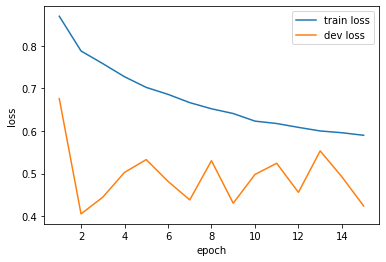

In [33]:
plt.figure()
plt.plot(np.arange(1, N_EPOCH+1), train_loss_list, label='train loss')
plt.plot(np.arange(1, N_EPOCH+1), dev_loss_list, label='dev loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [35]:
model = MLP(768, 4, 128, 0.3)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()


test_loss, test_acc, test_conf = evaluate(model, test_loader, criterion)

test_P, test_R, test_f1 = f1_score(test_conf)

print('test loss: %2.2f, test accuracy: %2.2f%%, test f1 score: %2.2f%%' %
      (test_loss, test_acc*100, test_f1*100))
print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
      (test_P[0], test_P[1], test_P[2], test_P[3], test_R[0], test_R[1], test_R[2], test_R[3]))

test loss: 0.42, test accuracy: 85.60%, test f1 score: 63.72%
P: 0.46 0.54 0.50 0.94 | R: 0.59 0.56 0.65 0.90


# **LSTM**

1-layer lstm + 2-layer dense network

## Model

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout):
        super().__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )


    def forward(self, x):
        xi_list = []
        for xi in x:
            xi, (_, _) = self.lstm(xi)
            xi, _ = torch.max(xi, dim=1)
            xi_list.append(xi)

        x = torch.concat(xi_list, dim=0)
        x  = self.net(x)

        return x


## Experiment

In [25]:
BATCH_SIZE = 20

train_loader = DataLoader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(X_dev, y_dev, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
model_path = 'models/baselineLSTM.pth'

model = LSTM(768, 4, 128, 0.3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8, verbose=True)

Adjusting learning rate of group 0 to 3.0000e-03.


In [39]:
N_EPOCH = 15

train_loss_list, dev_loss_list = [], []
min_f1 = 0

for epoch in range(N_EPOCH):
    train_loss, train_acc, train_conf = train(model, train_loader, optimizer, scheduler, criterion)
    dev_loss, dev_acc, dev_conf = evaluate(model, dev_loader, criterion)

    train_loss_list.append(train_loss)
    dev_loss_list.append(dev_loss)

    dev_P, dev_R, dev_f1 = f1_score(dev_conf)
    if dev_f1 > min_f1:
        torch.save(model.state_dict(), model_path)
        min_f1 = dev_f1

    print('[epoch %02d] train loss: %2.2f, dev loss: %2.2f, dev accuracy: %2.2f%%, dev f1 score: %2.2f%%' %
          (epoch+1, train_loss, dev_loss, dev_acc*100, dev_f1*100))
    print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
          (dev_P[0], dev_P[1], dev_P[2], dev_P[3], dev_R[0], dev_R[1], dev_R[2], dev_R[3]))

Adjusting learning rate of group 0 to 2.4000e-03.
[epoch 01] train loss: 0.55, dev loss: 0.57, dev accuracy: 79.00%, dev f1 score: 61.70%
P: 0.38 0.33 0.49 0.97 | R: 0.79 0.84 0.83 0.78
Adjusting learning rate of group 0 to 1.9200e-03.
[epoch 02] train loss: 0.46, dev loss: 0.46, dev accuracy: 83.16%, dev f1 score: 64.17%
P: 0.55 0.41 0.42 0.96 | R: 0.57 0.78 0.87 0.85
Adjusting learning rate of group 0 to 1.5360e-03.
[epoch 03] train loss: 0.44, dev loss: 0.39, dev accuracy: 84.67%, dev f1 score: 67.68%
P: 0.39 0.61 0.51 0.96 | R: 0.78 0.70 0.81 0.86
Adjusting learning rate of group 0 to 1.2288e-03.
[epoch 04] train loss: 0.42, dev loss: 0.45, dev accuracy: 83.74%, dev f1 score: 67.34%
P: 0.47 0.41 0.53 0.97 | R: 0.76 0.88 0.84 0.84
Adjusting learning rate of group 0 to 9.8304e-04.
[epoch 05] train loss: 0.40, dev loss: 0.35, dev accuracy: 86.12%, dev f1 score: 69.93%
P: 0.47 0.57 0.53 0.97 | R: 0.79 0.79 0.79 0.87
Adjusting learning rate of group 0 to 7.8643e-04.
[epoch 06] train los

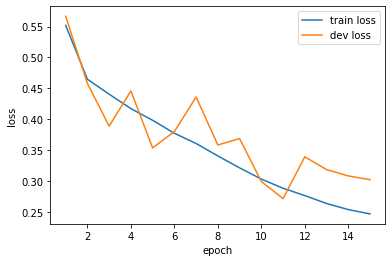

In [40]:
plt.figure()
plt.plot(np.arange(1, N_EPOCH+1), train_loss_list, label='train loss')
plt.plot(np.arange(1, N_EPOCH+1), dev_loss_list, label='dev loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [41]:
model = LSTM(768, 4, 128, 0.3)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()


test_loss, test_acc, test_conf = evaluate(model, test_loader, criterion)

test_P, test_R, test_f1 = f1_score(test_conf)

print('test loss: %2.2f, test accuracy: %2.2f%%, test f1 score: %2.2f%%' %
      (test_loss, test_acc*100, test_f1*100))
print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
      (test_P[0], test_P[1], test_P[2], test_P[3], test_R[0], test_R[1], test_R[2], test_R[3]))

test loss: 0.27, test accuracy: 89.66%, test f1 score: 74.38%
P: 0.63 0.67 0.57 0.96 | R: 0.64 0.77 0.85 0.92
